In [1]:
# Dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from dateutil.parser import parse

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
# Importing datatype
from sqlalchemy import Column, Integer, String, Float

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [7]:
# Column detail from measurement table
measurement_columns_df = pd.DataFrame(inspector.get_columns('measurement'))
measurement_columns_df

,name,type,nullable,default,autoincrement,primary_key
0,id,INTEGER,False,None,auto,1
1,station,TEXT,True,None,auto,0
2,date,TEXT,True,None,auto,0
3,prcp,FLOAT,True,None,auto,0
4,tobs,FLOAT,True,None,auto,0


In [8]:
# Column detail from station table
station_columns_df = pd.DataFrame(inspector.get_columns('station'))
station_columns_df

,name,type,nullable,default,autoincrement,primary_key
0,id,INTEGER,False,None,auto,1
1,station,TEXT,True,None,auto,0
2,name,TEXT,True,None,auto,0
3,latitude,FLOAT,True,None,auto,0
4,longitude,FLOAT,True,None,auto,0
5,elevation,FLOAT,True,None,auto,0


In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [10]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Get the last date the measurement recorded.
last_date_record = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = parse(last_date_record[0])

# Calculate the date 1 year ago from the last data point in the database
one_year_ago = last_date.replace(year=last_date.year-1) + dt.timedelta(days=1)

# convert to date calculated to string, as the data is stored as string
one_year_ago_st = one_year_ago.strftime("%Y-%m-%d")
last_date_st = last_date.strftime("%Y-%m-%d")
# last_date_st = "2016-08-29"
print(f"Last Date measured:{last_date_st}, 1 year from last Date:{one_year_ago_st}.")

Last Date measured:2017-08-23, 1 year from last Date:2016-08-24.


In [14]:
# Perform a query to retrieve the data and precipitation scores
OneYearPrcpData = session.query(Measurement.date, Measurement.prcp). \
    filter(Measurement.date>=one_year_ago_st). \
    filter(Measurement.date<=last_date_st). \
    order_by(Measurement.date).all()

# Display Data statistics
print(f"Record Count: {len(OneYearPrcpData)}")
print(f"Start Date: {OneYearPrcpData[0][0]}")
print(f"End Date: {OneYearPrcpData[len(OneYearPrcpData)-1][0]}")

Record Count: 2223
Start Date: 2016-08-24
End Date: 2017-08-23


In [15]:
# Save the query results as a Pandas DataFrame 
prcp_df = pd.DataFrame(OneYearPrcpData,columns=['Date', 'Precipitation'])

# remove dates that does not have any precip
prcp_df = prcp_df.dropna(how="any")

# Sort the dataframe by date
prcp_df = prcp_df.sort_values("Date")

# display the dataframe
prcp_df

,Date,Precipitation
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
4,2016-08-24,1.22
5,2016-08-24,2.15
...,...,...
2216,2017-08-22,0.00
2220,2017-08-23,0.00
2221,2017-08-23,0.08
2219,2017-08-23,0.00


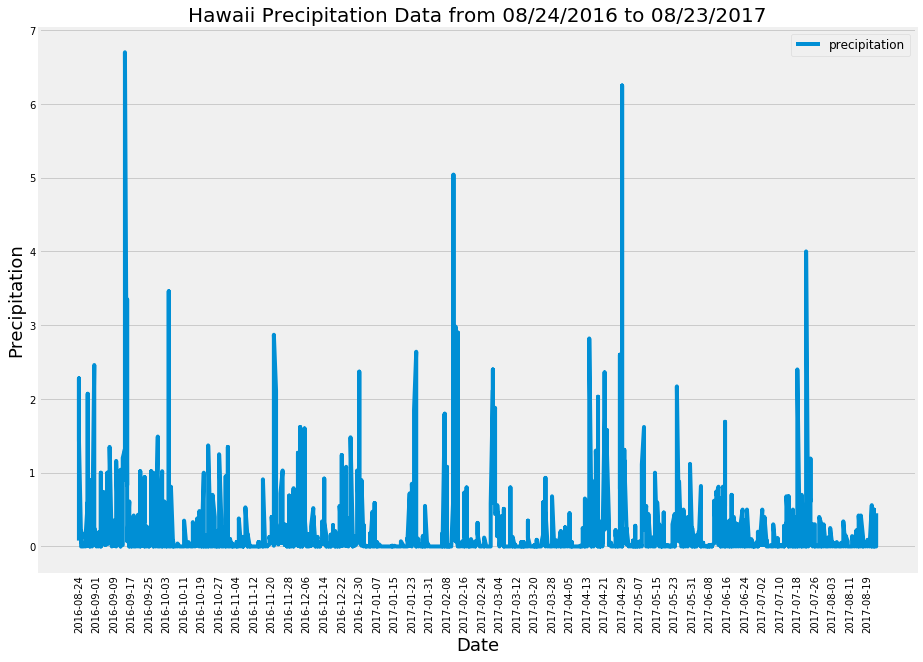

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(14,10))


x = np.arange(len(prcp_df["Date"]))
ax.plot(prcp_df["Date"], prcp_df["Precipitation"],label="precipitation")

oneYearAgo_dt = one_year_ago.strftime("%m/%d/%Y")
lastDate_dt = last_date.strftime("%m/%d/%Y")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.legend(loc="best", fontsize=12)
ax.set_title(f'Hawaii Precipitation Data from {oneYearAgo_dt} to {lastDate_dt}', fontdict={"size":20})
ax.set_xlabel('Date', fontdict={"size":18})
ax.set_ylabel('Precipitation', fontdict={"size":18})
plt.xticks(rotation="vertical")
ax.xaxis.set_major_locator(plt.MaxNLocator(52))

# ax.set_xticks(x)


plt.grid(False, axis="x", which="major")
plt.show()
fig.tight_layout()
fig.savefig("Output/One_Year_Precipitation_Bar.png")

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print("Statistical Summary of the One year precipitation data:")
prcp_df.describe()

Statistical Summary of the One year precipitation data:


,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).count()
print(f"Total number of stations: {station_count}")

Total number of stations: 9


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_byCount = session.query(Station.station,Station.name, func.count(Measurement.id)). \
    filter(Station.station == Measurement.station). \
    group_by(Station.station,Station.name). \
    order_by(func.count(Measurement.id).desc()). \
    all()

# Save the query results as a Pandas DataFrame 
station_byCount_df = pd.DataFrame(station_byCount,columns=['Station', 'Name', 'Count of Measurements'])

# display the dataframe
station_byCount_df

,Station,Name,Count of Measurements
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,USC00517948,"PEARL CITY, HI US",1372
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = station_byCount[0][0]
record_MAS = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)). \
    filter(Measurement.station==most_active_station). \
    group_by(Measurement.station).all()

print(f"Lowest Temp. Recorded by {most_active_station} is: {record_MAS[0][0]}")
print(f"Highest Temp. Recorded by {most_active_station} is: {record_MAS[0][1]}")
print(f"Average Temp. Recorded by {most_active_station} is: {record_MAS[0][2]}")

Lowest Temp. Recorded by USC00519281 is: 54.0
Highest Temp. Recorded by USC00519281 is: 85.0
Average Temp. Recorded by USC00519281 is: 71.66378066378067


In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
OneYearTemp_MAS = session.query(Measurement.date, Measurement.tobs). \
    filter(Measurement.date>=one_year_ago_st). \
    filter(Measurement.date<=last_date_st). \
    filter(Measurement.station==most_active_station). \
    order_by(Measurement.date).all()

# Display Data statistics
print(f"Record Count: {len(OneYearTemp_MAS)}")
print(f"Start Date: {OneYearTemp_MAS[0][0]}")
print(f"End Date: {OneYearTemp_MAS[len(OneYearTemp_MAS)-1][0]}")

Record Count: 351
Start Date: 2016-08-24
End Date: 2017-08-18


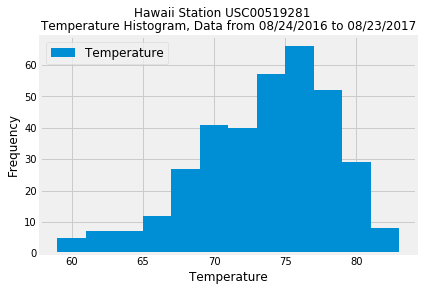

In [22]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
OneYearTemp_MAS_df = pd.DataFrame(OneYearTemp_MAS, columns=['Date','Temperature'])
fig, ax = plt.subplots()

#Create histogram
ax.hist(OneYearTemp_MAS_df['Temperature'], bins=12,label='Temperature')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.legend(loc="best", fontsize=12)
fig.suptitle(f'Hawaii Station {most_active_station}', fontsize=12)
ax.set_title(f'Temperature Histogram, Data from {oneYearAgo_dt} to {lastDate_dt}', fontdict={"size":12})
ax.set_xlabel('Temperature', fontdict={"size":12})
ax.set_ylabel('Frequency', fontdict={"size":12})
plt.show()
fig.savefig("Output/Temperature_Histogram.png")

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# last measured temperature is till Aug 23rd 2017, so assume the trip in July
trip_start = dt.date(2018,7,1)
trip_end = trip_start + dt.timedelta(days=7)

# get the dates for previous year
pre_year_start = trip_start.replace(year=trip_start.year-1)
pre_year_start_str = pre_year_start.strftime("%Y-%m-%d")

pre_year_end = trip_end.replace(year=trip_end.year-1)
pre_year_end_str = pre_year_end.strftime("%Y-%m-%d")

# 
tmin, tavg, tmax = calc_temps(pre_year_start_str, pre_year_end_str)[0]
print(f"tmin:{tmin}, tavg:{tavg}, tmax:{tmax}")

tmin:71.0, tavg:78.04347826086956, tmax:87.0


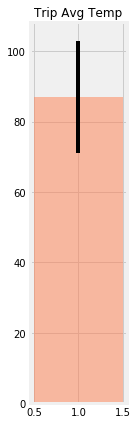

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots(figsize=(2,6))
yerr = tmax-tmin

ax.bar(1, tmax, yerr=yerr, width=1,color="coral", alpha=0.5)

ax.set_title('Trip Avg Temp', fontdict={"size":12})

fig.tight_layout()
plt.show()

# Save the plot
fig.savefig("Output/Trip_Average_Temp.png")

In [26]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
Station_rainfall = session.query(Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)). \
    filter(Station.station == Measurement.station). \
    filter(Measurement.date>=pre_year_start_str). \
    filter(Measurement.date<=pre_year_end_str). \
    group_by(Station.station,Station.name). \
    order_by(func.sum(Measurement.prcp).desc()). \
    all()

# Save the query results as a Pandas DataFrame 
Station_rainfall_df = pd.DataFrame(Station_rainfall,columns=['station', 'name', 'latitude', 'longitude', 'elevation', 'rainfall'])

# display the dataframe
print(f"Total Rainfall between: '{pre_year_start_str}' and '{pre_year_end_str}'")
Station_rainfall_df


Total Rainfall between: '2017-07-01' and '2017-07-08'


,station,name,latitude,longitude,elevation,rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,1.34
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.64
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.31
3,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.12
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.06
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.02
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


## Optional Challenge Assignment

In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [28]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start = dt.date(2018,7,1)
trip_end = trip_start + dt.timedelta(days=7)

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(trip_start, trip_end, freq='D')

# Stip off the year and save a list of %m-%d strings
trip_month_dates = trip_dates.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for month_date in trip_month_dates:
    normals.append(daily_normals(month_date)[0])

normals

[(67.0, 74.77777777777777, 81.0),
 (68.0, 75.40384615384616, 82.0),
 (68.0, 75.32075471698113, 87.0),
 (70.0, 76.57142857142857, 81.0),
 (66.0, 75.0, 81.0),
 (69.0, 75.0, 81.0),
 (69.0, 74.91071428571429, 82.0),
 (69.0, 76.08333333333333, 83.0)]

In [29]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normal_df = pd.DataFrame(normals,columns=['tmin', 'tavg', 'tmax'])

daily_normal_df["date"] = trip_dates

# set date as index
daily_normal_df.set_index("date",inplace=True)

daily_normal_df

,tmin,tavg,tmax
date,,,
2018-07-01,67.0,74.777778,81.0
2018-07-02,68.0,75.403846,82.0
2018-07-03,68.0,75.320755,87.0
2018-07-04,70.0,76.571429,81.0
2018-07-05,66.0,75.000000,81.0
2018-07-06,69.0,75.000000,81.0
2018-07-07,69.0,74.910714,82.0
2018-07-08,69.0,76.083333,83.0


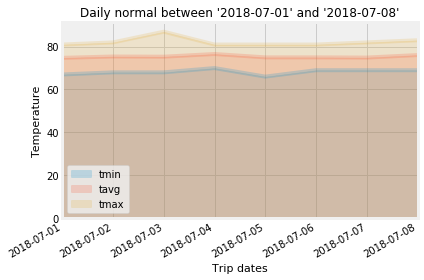

In [30]:
# Plot the daily normals as an area plot with `stacked=False`
daily_norm_plot = daily_normal_df.plot(kind='area', stacked=False, x_compat=True, alpha=.2)
plt.title(f"Daily normal between '{trip_start}' and '{trip_end}'", fontdict={"size":12})
plt.xlabel("Trip dates", fontdict={"size":11})
plt.ylabel("Temperature", fontdict={"size":11})
plt.tight_layout()
plt.show()

# Save the plot
daily_norm_plot.figure.savefig("Output/Trip_Daily_Normals.png")